# Question 2

A data follows the following model for a time series:
- Use the notebook get GNP data.ipynb to get the data
- Use AR model on rgnp to predict the last 10 observations. 
    - Adjust the number of lags to consider using any model selection criteria you choose.
- Use VAR model (vector auto-regressive) to predict the last 10 observations of the data
- Replace the prediction models in the last two sections with corresponding LSTM models.
    - The LSTM models should be implemeted in PyTorch. 
    - You should optimize the hidden state size using validation set.
    
Hint: 
- For the regression model you may prefer to work on derivatives of the series. 
- You can check the order of derivation using Augmented Dickey-Fuller test.

In [1]:
import numpy as np
import pandas as pd

In [2]:
filepath = 'https://raw.githubusercontent.com/selva86/datasets/master/Raotbl6.csv'
df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
test_samples = 10
train_df = df[:-test_samples]
test_df = df[len(train_df):]
# print(df.shape)  # (123, 8)
df.tail()

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1988-07-01,4042.7,3971.9,179.6,131.5,124.9,106.2,123.5,92.8
1988-10-01,4069.4,3995.8,181.3,133.3,126.2,107.3,124.9,92.9
1989-01-01,4106.8,4019.9,184.1,134.8,127.7,109.5,126.6,94.0
1989-04-01,4132.5,4044.1,186.1,134.8,129.3,111.1,129.0,100.6
1989-07-01,4162.9,4068.4,187.4,137.2,130.2,109.8,129.9,98.2


1. rgnp  : Real GNP.
2. pgnp  : Potential real GNP.
3. ulc   : Unit labor cost.
4. gdfco : Fixed weight deflator for personal consumption expenditure excluding food and energy.
5. gdf   : Fixed weight GNP deflator.
6. gdfim : Fixed weight import deflator.
7. gdfcf : Fixed weight deflator for food in personal consumption expenditure.
8. gdfce : Fixed weight deflator for energy in personal consumption expenditure.

## Using AR(p) model for rgnp

### Testing for stationarity

In [3]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train_df['rgnp'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.081173
p-value: 0.964752


### rndp is not stationary - try fix using first derivative

In [4]:
rgnp_diff = train_df['rgnp'].diff().dropna()
# rgnp_diff = np.log(train_df['rgnp']).diff().dropna()
result = adfuller(rgnp_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -5.355104
p-value: 0.000004


#### Now it is stationary

### Find the number of required lags/AR terms (order of p)

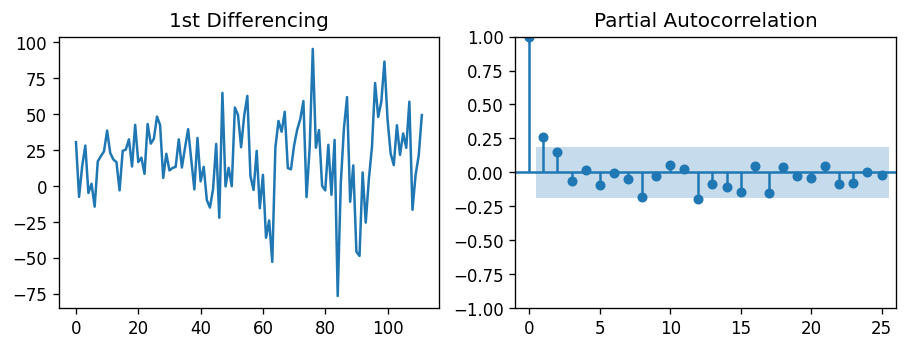

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(rgnp_diff.values); axes[0].set_title('1st Differencing')
axes[1].set(xlim=(-1 ,26))
plot_pacf(rgnp_diff.values, lags=25, method='ywm', ax = axes[1])

plt.show()

- PACF lag 1 is quite significant since is well above the significance line. 
- Lag 2 turns out to be significant as well, slightly managing to cross the significance limit (blue region)

### Instantiate and fit the AR(2) model with training data

In [6]:
from statsmodels.tsa.ar_model import AutoReg
ar_model = AutoReg(rgnp_diff, lags=2).fit()

# print(ar_model.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


### Plot the prediction vs test data

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and NumericIndex with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


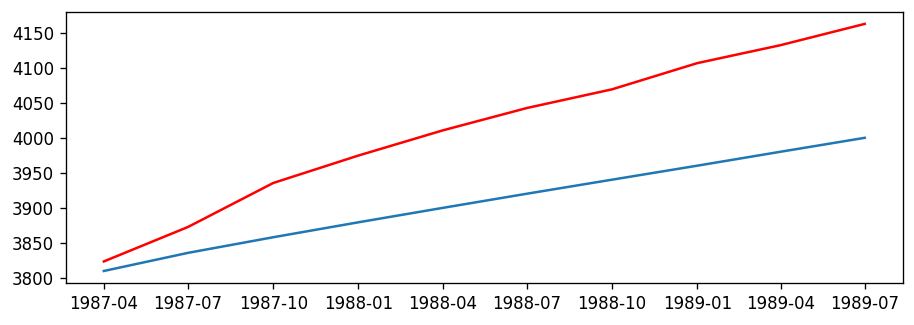

In [7]:
ar2_test_pred = ar_model.predict(start=test_df.index[0], end=test_df.index[-1], dynamic=False)
# invert derivative
ar2_test_pred = train_df['rgnp'][-1] + ar2_test_pred.cumsum()
from matplotlib import pyplot
pyplot.plot(ar2_test_pred)
pyplot.plot(test_df['rgnp'], color='red')

## Using VAR(p) model for the data

### Testing for stationarity

In [8]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [9]:
# # ADF Test on each column
# for name, column in train_df.iteritems():
#     adfuller_test(column, name=column.name)
#     print('\n')

**No stationary columns**

In [10]:
# 1st difference
df_differenced = train_df.diff().dropna()

In [11]:
# # ADF Test on each column
# for name, column in df_differenced.iteritems():
#     adfuller_test(column, name=column.name)
#     print('\n')

**Partial stationary columns**

In [12]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [13]:
# # ADF Test on each column
# for name, column in df_differenced.iteritems():
#     adfuller_test(column, name=column.name)
#     print('\n')

**Now all columns are stationary**

### Select the Order (P) of VAR model

In [14]:
from statsmodels.tsa.api import VAR

model = VAR(df_differenced)
x = model.select_order()
x.summary()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,-0.2774,-0.06900*,0.7577,-0.1931
1,-0.8140,1.062,0.4448,-0.05485
2,-1.143,2.400,0.3276,0.2914
3,-1.400,3.810,0.2689,0.7088
4,-1.624,5.254,0.2421,1.160
5,-1.455,7.090,0.3515,2.003
6,-2.307,7.905,0.2080,1.826
7,-2.979,8.900,0.1757,1.829
8,-3.836,9.711,0.1602,1.647
9,-5.609,9.606,0.08812,0.5488


#### All except FPE are lowest for lag=11

### Fit VAR(11) model

In [15]:
model_fitted = model.fit(11)
# model_fitted.summary()

In [16]:
# Get the lag order
lag_order = model_fitted.k_ar
# print(lag_order)  # --> 11

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]

# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=test_samples)
df_forecast = pd.DataFrame(fc, index=test_df.index[0:], columns=test_df.columns + '_2d')
# df_forecast

In [17]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [18]:
df_results = invert_transformation(train_df, df_forecast, second_diff=True)
df_var_11_forecast = df_results.filter(regex='_forecast$', axis=1)
df_var_11_forecast.columns = df.columns
df_var_11_forecast

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1987-04-01,3422.625877,3844.401398,177.255785,126.560053,117.558081,93.745173,115.148100,82.494347
1987-07-01,3589.066872,3866.687519,176.479915,130.534043,116.263370,84.132794,110.061534,67.358491
1987-10-01,3779.387094,3895.697083,174.766825,127.153748,116.132400,85.141480,106.805043,52.408782
1988-01-01,3959.536812,3932.249489,175.460773,122.206504,116.991494,94.068330,112.939259,62.271603
1988-04-01,3783.824208,3962.912912,181.078824,124.790597,119.132778,101.145354,117.220617,80.086329
1988-07-01,3706.441707,3978.678252,181.750303,134.860558,118.893528,94.508186,115.162757,81.972971
1988-10-01,3928.567685,3997.838580,179.269555,142.115860,116.563022,81.440897,108.529130,50.906793
1989-01-01,4475.544954,4037.320857,179.274036,134.065857,115.411475,90.238596,106.709595,23.202910
1989-04-01,4633.831952,4090.166813,186.449961,121.351618,119.888432,116.407634,117.221624,47.202560


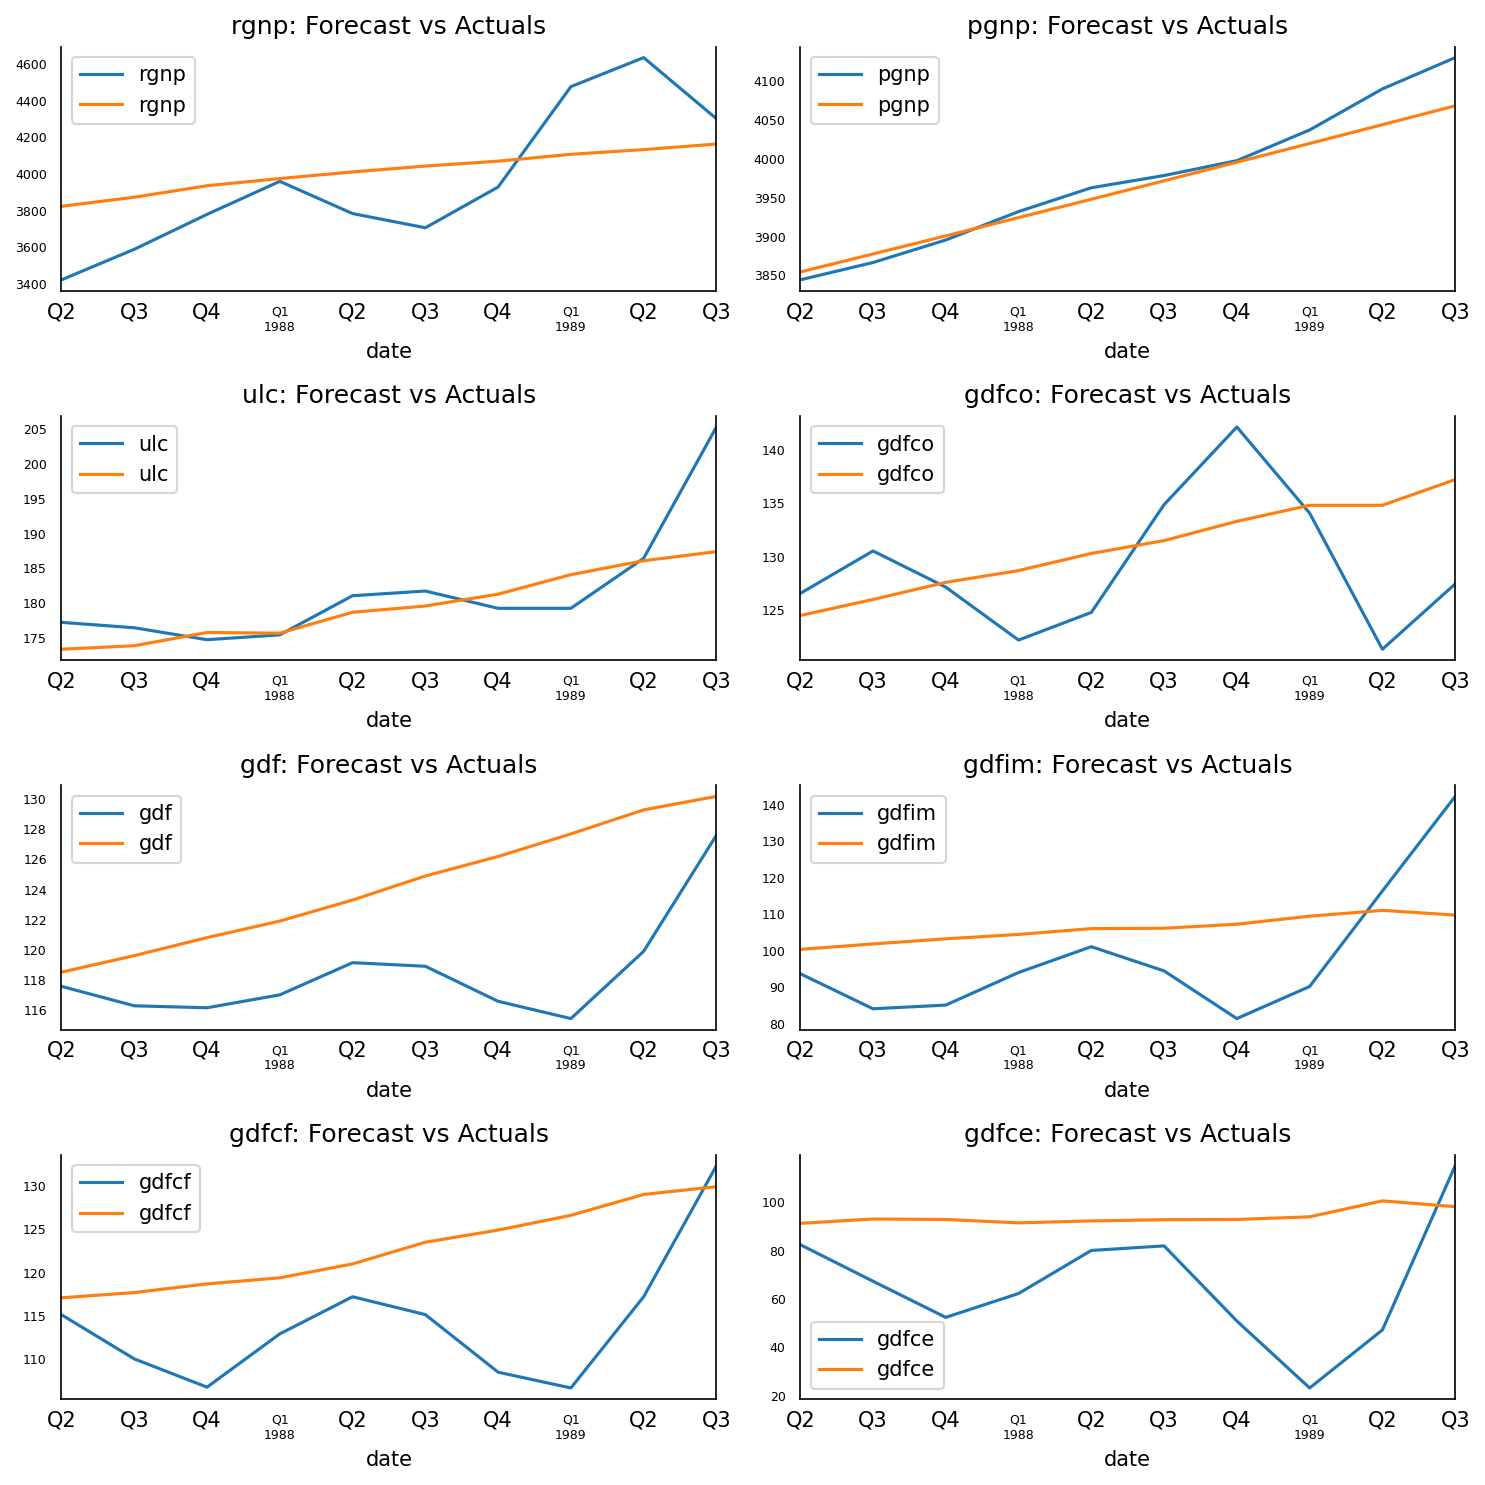

In [19]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_var_11_forecast[col].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    test_df[col].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

## Using LSTM

In [24]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [25]:
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable
sc = MinMaxScaler()

def prepare_lstm_data(df, lag):
    def sliding_windows(data, seq_length):
        x = []
        y = []

        for i in range(len(data)-seq_length-1):
            _x = data[i:(i+seq_length)]
            _y = data[i+seq_length]
            x.append(_x)
            y.append(_y)

        return np.array(x),np.array(y)
    
    training_set = df.values.reshape(-1,df.shape[1])
    training_data = sc.fit_transform(training_set)

    seq_length = lag
    x, y = sliding_windows(training_data, seq_length)
    
    dataX = Variable(torch.Tensor(np.array(x)))
    dataY = Variable(torch.Tensor(np.array(y)))

    return dataX, dataY

In [26]:
def fit_lstm(trainX, trainY, num_classes, input_size, hidden_size, num_layers, learning_rate=0.01, num_epochs=2000):
    lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
    #optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

    # Train the model
    for epoch in range(num_epochs):
        outputs = lstm(trainX)
        optimizer.zero_grad()

        # obtain the loss function
        loss = criterion(outputs, trainY)

        loss.backward()

        optimizer.step()
        if epoch % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    return lstm

### LSTM for AR(2)

Epoch: 0, loss: 0.15599
Epoch: 100, loss: 0.00073
Epoch: 200, loss: 0.00042
Epoch: 300, loss: 0.00039
Epoch: 400, loss: 0.00036
Epoch: 500, loss: 0.00034
Epoch: 600, loss: 0.00032
Epoch: 700, loss: 0.00030
Epoch: 800, loss: 0.00028
Epoch: 900, loss: 0.00026
Epoch: 1000, loss: 0.00025
Epoch: 1100, loss: 0.00023
Epoch: 1200, loss: 0.00021
Epoch: 1300, loss: 0.00020
Epoch: 1400, loss: 0.00019
Epoch: 1500, loss: 0.00017
Epoch: 1600, loss: 0.00016
Epoch: 1700, loss: 0.00014
Epoch: 1800, loss: 0.00013
Epoch: 1900, loss: 0.00012


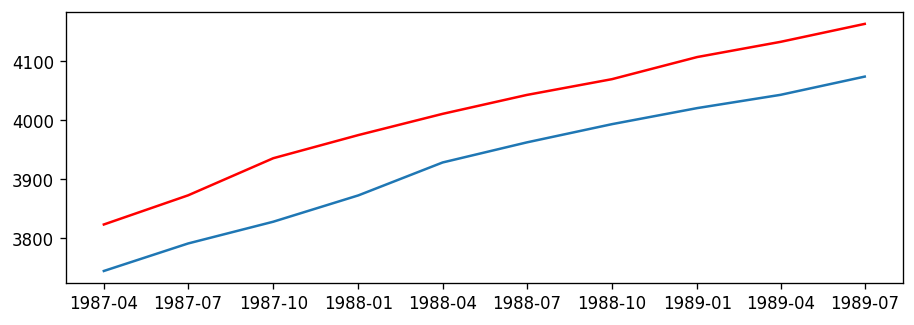

In [27]:
dataX, dataY = prepare_lstm_data(pd.DataFrame(df['rgnp']), lag=2)
trainX, testX = dataX[:-10,:,:], dataX[-10:,:,:]
trainY, testY = dataY[:-10,:], dataY[-10:,:]

lstm_ar2 = fit_lstm(trainX, trainY, num_classes=1, input_size=1, hidden_size=2, num_layers=1)

lstm_ar2_pred = lstm_ar2(testX).data.numpy()
lstm_ar2_pred = sc.inverse_transform(lstm_ar2_pred)
lstm_ar2_pred = pd.Series(np.array(lstm_ar2_pred).reshape(-1), index=test_df.index)

from matplotlib import pyplot
pyplot.plot(lstm_ar2_pred)
pyplot.plot(test_df['rgnp'], color='red')

### LSTM for VAR(2)

In [28]:
dataX, dataY = prepare_lstm_data(df, lag=11)
trainX, testX = dataX[:-10,:,:], dataX[-10:,:,:]
trainY, testY = dataY[:-10,:], dataY[-10:,:]

lstm_var11 = fit_lstm(trainX, trainY, num_classes=8, input_size=8, hidden_size=16, num_layers=1)

lstm_var11_pred = lstm_var11(testX).data.numpy()
lstm_var11_pred = sc.inverse_transform(lstm_var11_pred)
lstm_var11_pred = pd.DataFrame(lstm_var11_pred, index=test_df.index, columns=test_df.columns)

Epoch: 0, loss: 0.34086
Epoch: 100, loss: 0.00135
Epoch: 200, loss: 0.00076
Epoch: 300, loss: 0.00043
Epoch: 400, loss: 0.00034
Epoch: 500, loss: 0.00028
Epoch: 600, loss: 0.00023
Epoch: 700, loss: 0.00019
Epoch: 800, loss: 0.00016
Epoch: 900, loss: 0.00014
Epoch: 1000, loss: 0.00013
Epoch: 1100, loss: 0.00011
Epoch: 1200, loss: 0.00010
Epoch: 1300, loss: 0.00011
Epoch: 1400, loss: 0.00009
Epoch: 1500, loss: 0.00008
Epoch: 1600, loss: 0.00007
Epoch: 1700, loss: 0.00006
Epoch: 1800, loss: 0.00006
Epoch: 1900, loss: 0.00006


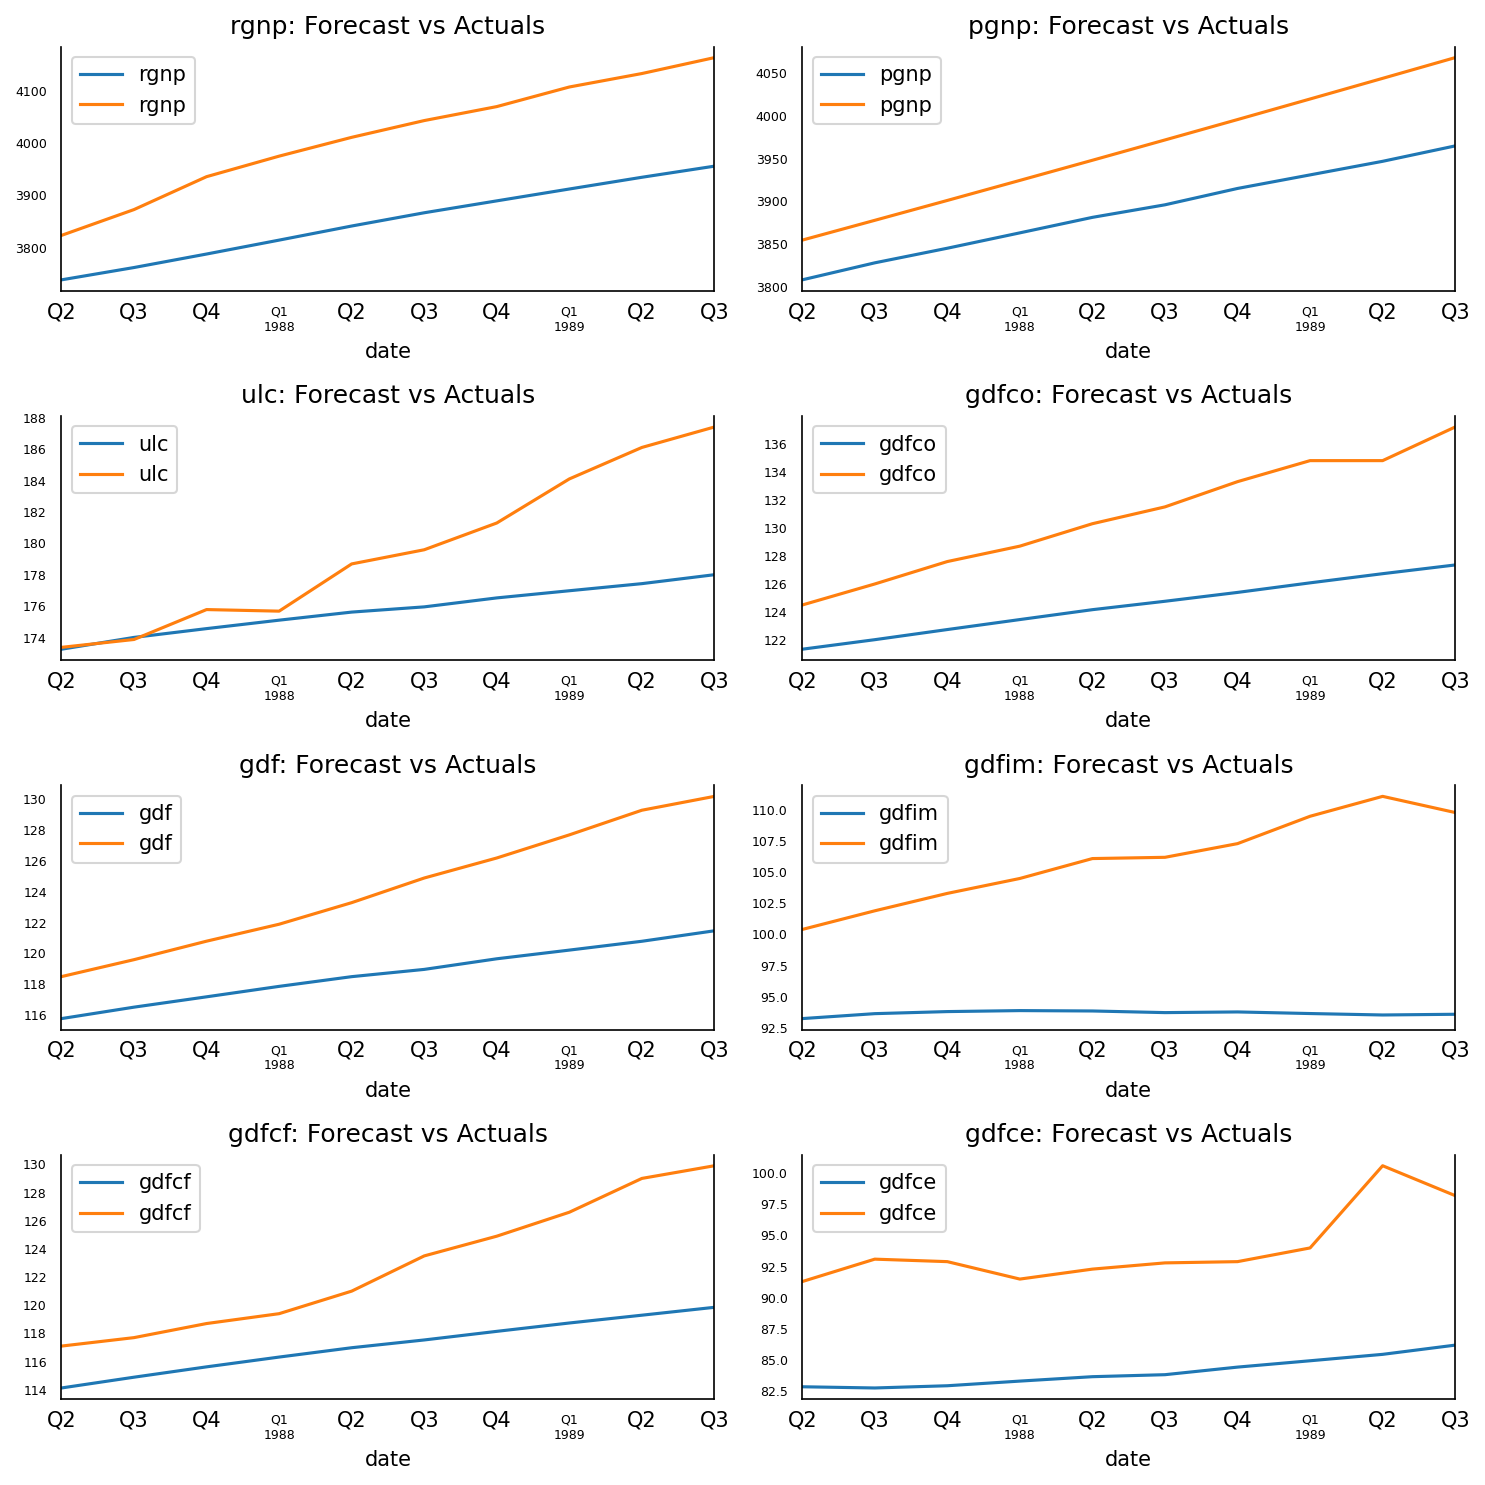

In [29]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    lstm_var11_pred[col].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    test_df[col].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

## Compare the models using test MSE

In [71]:
mse = lambda pred, actual: (np.square(pred - actual)).mean()

lstm_var11_mse = mse(lstm_var11_pred, test_df)
lstm_var11_mse.name="LSTM-VAR(11)"
var11_mse = mse(df_var_11_forecast, test_df)
var11_mse.name="VAR(11)"

lstm_ar2_mse = mse(lstm_ar2_pred, test_df['rgnp'])
lstm_ar2_mse = pd.Series(lstm_ar2_mse, index=['rgnp'], name="LSTM-AR(2)")
ar2_mse = mse(ar2_test_pred, test_df['rgnp'])
ar2_mse = pd.Series(ar2_mse, index=['rgnp'], name="AR(2)")

mse_df = pd.concat([lstm_var11_mse, var11_mse, lstm_ar2_mse, ar2_mse], axis=1).T
mse_df

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
LSTM-VAR(11),27908.310111,5641.526936,26.040526,46.005335,35.176416,163.516116,39.001799,102.701720
VAR(11),85656.233418,685.763894,38.061255,46.294600,45.047919,308.627579,113.736595,1341.395451
LSTM-AR(2),7721.964315,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AR(2),13171.978984,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

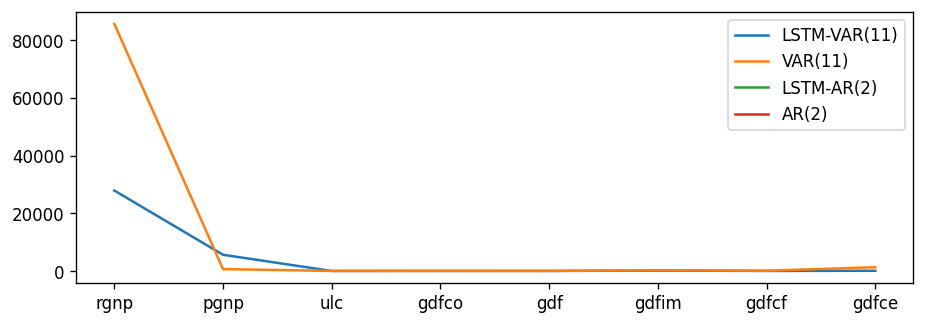

In [72]:
mse_df.T.plot()

## Summary
Except *pgnp* in VAR(11) model, LSTM was superior on any aspect.